# EDA: Tarifas

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [309]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random

from statsmodels.graphics.tsaplots import plot_acf

import torch

import pytorch_common.util    as pu
from util   import set_seed

from scipy import stats
from scipy.signal import savgol_filter

import data as dt

## Setup

In [4]:
pu.LoggerBuilder().on_console().build()

<RootLogger root (INFO)>

In [5]:
pu.set_device_name('cpu')

In [6]:
pu.get_device()

device(type='cpu')

In [7]:
torch.cuda.is_available()

True

In [8]:
torch.__version__

'1.12.1+cu116'

In [9]:
set_seed(42)

In [10]:
DATASET_PATH = '../datasets/tarifas.csv'

Cargamos el dataset y ordenamos por fecha ascendente:

In [34]:
rates = pd.read_csv(DATASET_PATH)
rates.columns = rates.columns.str.lower()

rates['date'] = rates['month'].apply(lambda x: f'01-{x}') 
rates['date'] = pd.to_datetime(rates['date'], format="%d-%m-%Y")

rates = rates.drop(columns=['month'])
rates = rates.sort_values(['date', 'empresa'], ascending=True)

rates['cargo_fijo'] = pd.to_numeric(rates['cargo_fijo'])
rates['cargo_var']  = pd.to_numeric(rates['cargo_var'])
rates['cargo_fijo_unidad'] = rates['cargo_fijo_unidad'].apply(lambda x: x.replace('.', ''))
                                                         
rates.head()

,empresa,type,cargo_fijo_unidad,cargo_fijo,cargo_var_unidad,cargo_var,date
207,EDENOR,Tarifa 1 - R2,$/bim,21.59,$/kWh,0.049,2014-01-01
206,EDESUR,Tarifa 1 - R2,$/bim,20.35,$/kWh,0.048,2014-01-01
205,EDENOR,Tarifa 1 - R2,$/bim,21.59,$/kWh,0.049,2014-02-01
204,EDESUR,Tarifa 1 - R2,$/bim,20.35,$/kWh,0.048,2014-02-01
203,EDENOR,Tarifa 1 - R2,$/bim,21.59,$/kWh,0.049,2014-03-01


Llevamos los cargos bimestrales a mensuales:

In [36]:
rates['cargo_fijo_unidad'].value_counts()

$/mes    122
$/bim     86
Name: cargo_fijo_unidad, dtype: int64

In [42]:
rates['cargo_fijo'] = np.where(rates['cargo_fijo_unidad'] == '$/bim', rates['cargo_fijo']/2, rates['cargo_fijo'])

In [43]:
rates.head()

,empresa,type,cargo_fijo_unidad,cargo_fijo,cargo_var_unidad,cargo_var,date
207,EDENOR,Tarifa 1 - R2,$/bim,10.795,$/kWh,0.049,2014-01-01
206,EDESUR,Tarifa 1 - R2,$/bim,10.175,$/kWh,0.048,2014-01-01
205,EDENOR,Tarifa 1 - R2,$/bim,10.795,$/kWh,0.049,2014-02-01
204,EDESUR,Tarifa 1 - R2,$/bim,10.175,$/kWh,0.048,2014-02-01
203,EDENOR,Tarifa 1 - R2,$/bim,10.795,$/kWh,0.049,2014-03-01


In [53]:
edenor = rates[rates['empresa'] =='EDENOR']
edesur = rates[rates['empresa'] =='EDESUR']

### Edenor

<Figure size 1440x216 with 1 Axes>

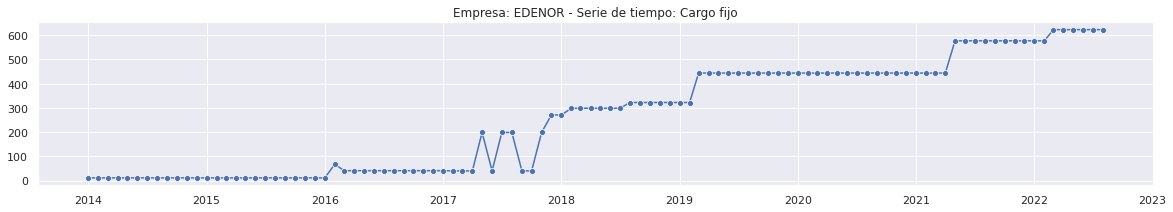

<Figure size 1440x216 with 1 Axes>

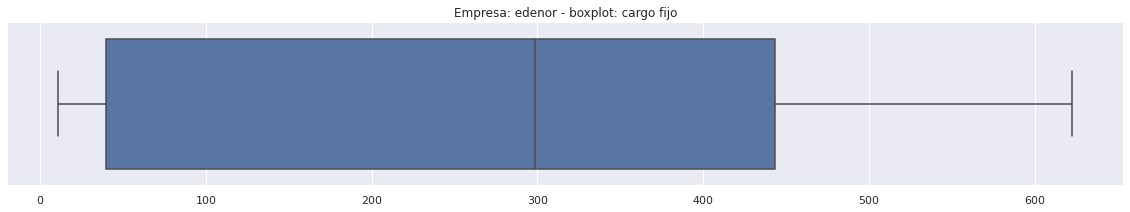

<Figure size 1440x216 with 1 Axes>

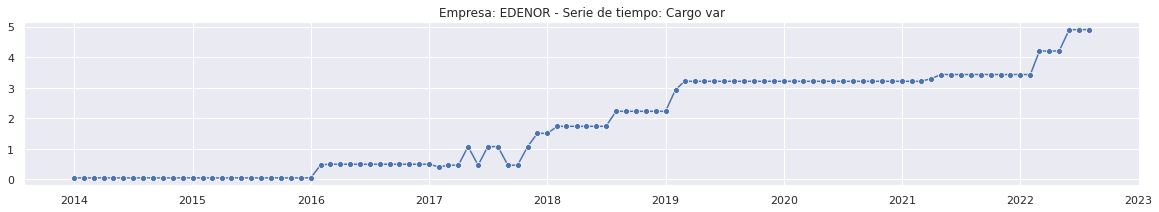

<Figure size 1440x216 with 1 Axes>

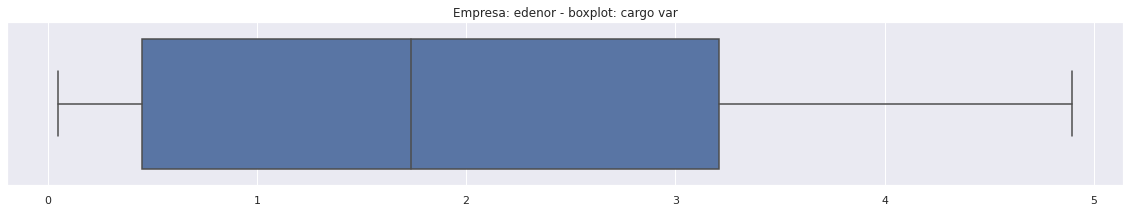

In [72]:
dt.plot_ts_var(edenor, 'date', 'cargo_fijo', title_prefix='Empresa: EDENOR - ')
dt.plot_ts_var(edenor, 'date', 'cargo_var',  title_prefix='Empresa: EDENOR - ')

### Edesur

<Figure size 1440x216 with 1 Axes>

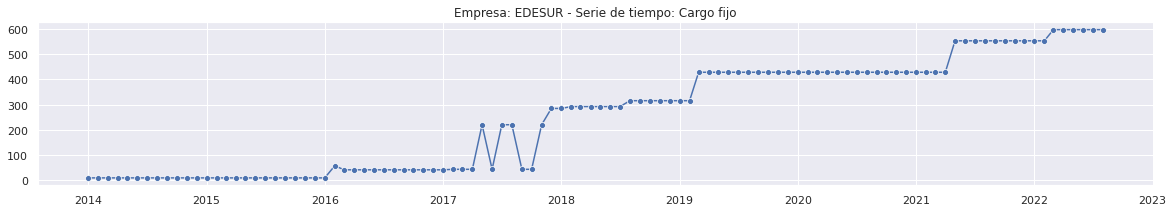

<Figure size 1440x216 with 1 Axes>

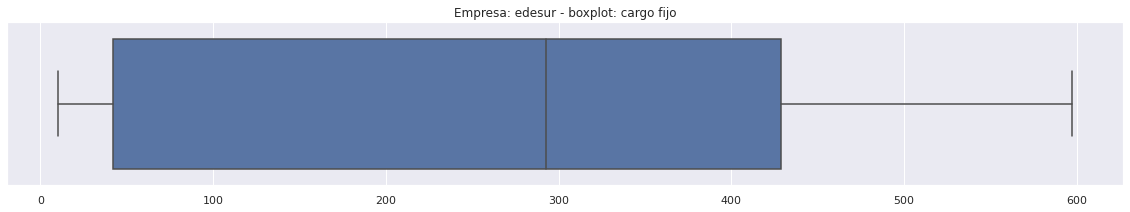

<Figure size 1440x216 with 1 Axes>

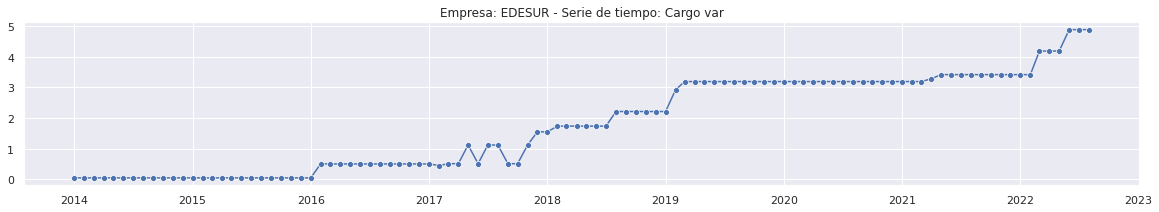

<Figure size 1440x216 with 1 Axes>

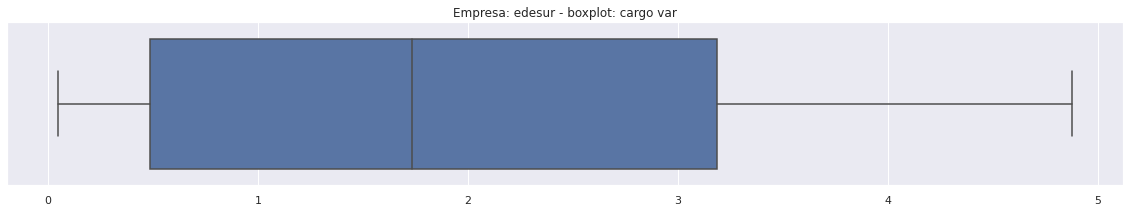

In [74]:
dt.plot_ts_var(edesur, 'date', 'cargo_fijo', title_prefix='Empresa: EDESUR - ')
dt.plot_ts_var(edesur, 'date', 'cargo_var',  title_prefix='Empresa: EDESUR - ')

## Filtro de media movil (smothing o filtro pasa bajo)

Permite visualizar la tendencia de una serie temporal.

In [413]:
def centered_rolling_average(df, column, window, circular=False):    
    first_values = df[column].values[-(window-1)] if circular else np.zeros(window-1)
    values = pd.Series(np.concatenate((first_values, df[column].values)))
    return values.rolling(window=window).mean().dropna().values

def columns_as_category(df):
    return df.stack().reset_index().rename(columns={
      'level_1': 'column', 0: 'value'
    }).drop(columns=['level_0']).reset_index()


WINDOW  = 12 # Meses

    

def moving_average_plot(df, column, window, xlabel='Año', freq_zoom=30):
    original = df[column].values
    anual    = circular_centered_rolling_average(df, column, window)
    diff     = anual - original
    time_df = columns_as_category(pd.DataFrame({'Mensual': original, 'Media Movil Anual': anual, 'Diff': diff}))
    
    sns.set(rc = {'figure.figsize':(20, 8)})
    sns.lineplot(x="index", y='value', hue='column',  data=time_df)
    plt.show()

    sns.set(rc = {'figure.figsize':(10,15 )})
    freq_df = columns_as_category(
        pd.DataFrame({
            'Mensual'           : np.real(np.fft.rfft(original))[:freq_zoom],
            'Media Movil Anual' : np.real(np.fft.rfft(anual))[:freq_zoom],
            'Diff'              : np.real(np.fft.rfft(diff))[:freq_zoom]
        })
    )
    sns.lineplot(x="index", y='value', hue='column', data=freq_df)


### Edenor

Cargo fijo:

<Figure size 1440x576 with 1 Axes>

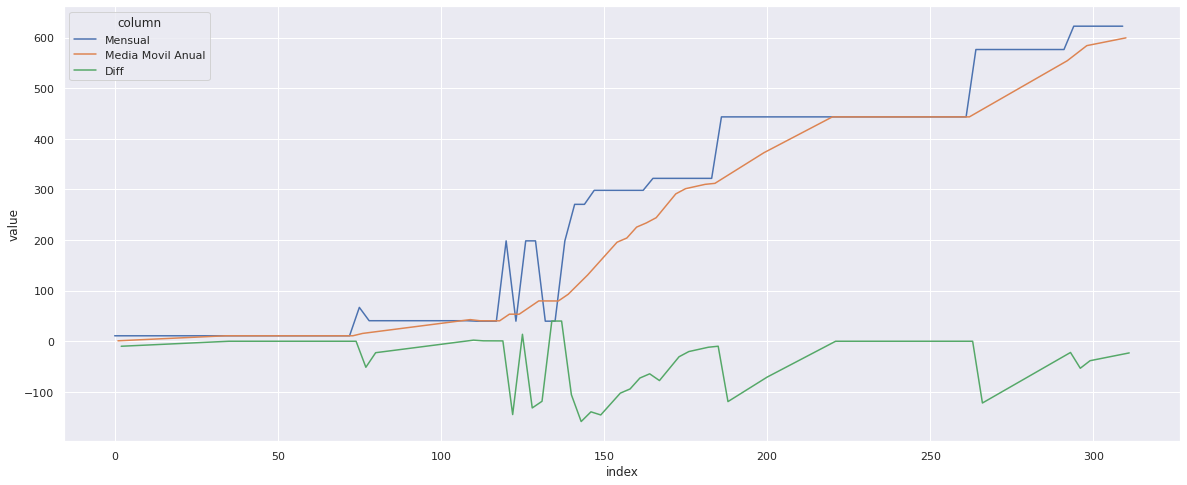

<Figure size 720x1080 with 1 Axes>

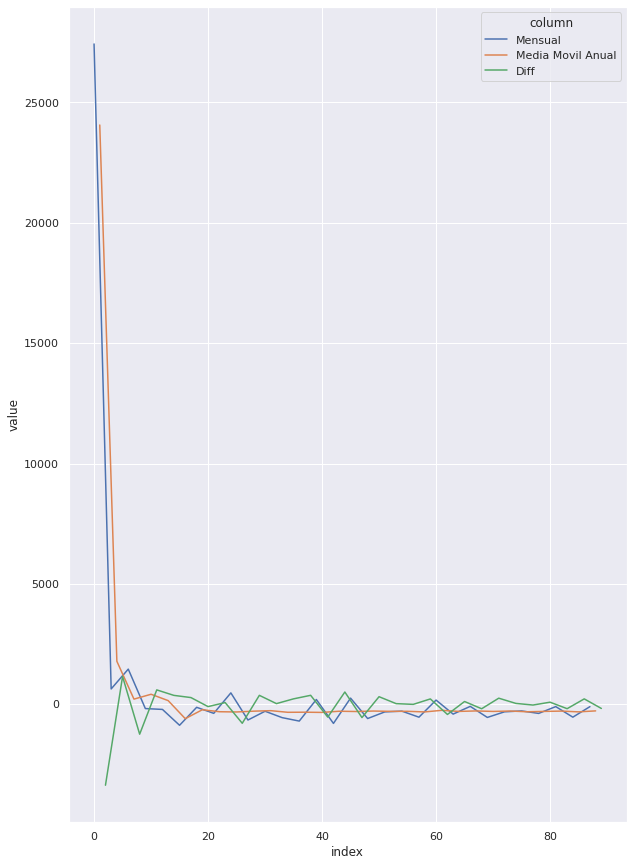

In [414]:
moving_average_plot(edenor, 'cargo_fijo', WINDOW)

Observaciones:

* Cuando masgrande esl a ventana de smothing mas se aminoran la altas freciencias. pro esta rrazon la componenta a la cual le aplicamos la mediao movil tiene componentes en freciencia de menor grado que la señal original.

Cago Variable:

<Figure size 1440x576 with 1 Axes>

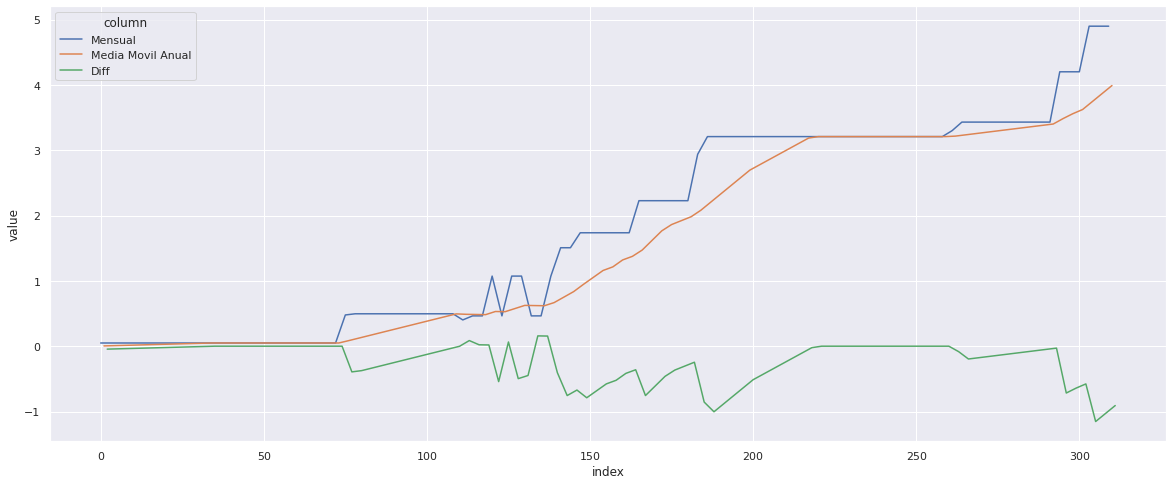

<Figure size 720x1080 with 1 Axes>

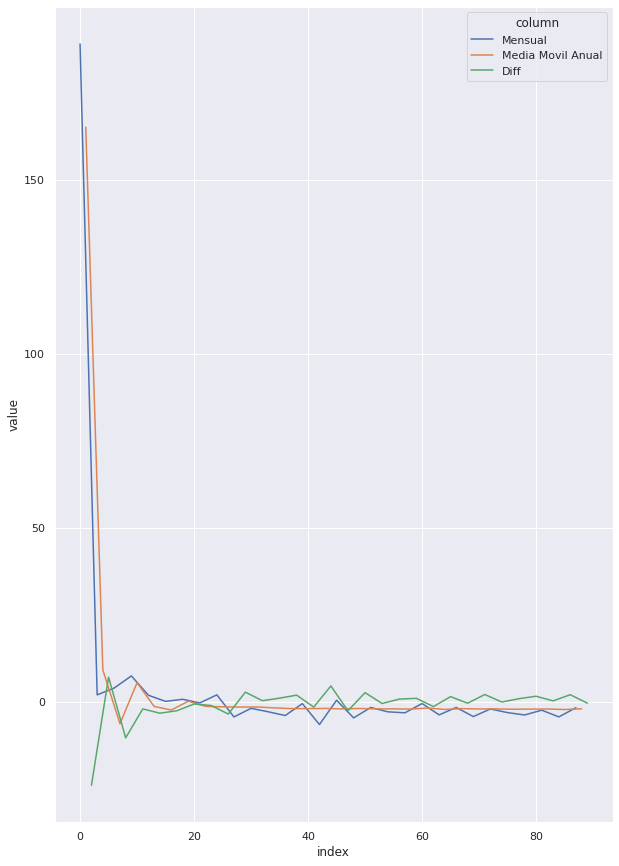

In [415]:
moving_average_plot(edenor, 'cargo_var', WINDOW)

### Edesur

Cargo fijo:

<Figure size 1440x576 with 1 Axes>

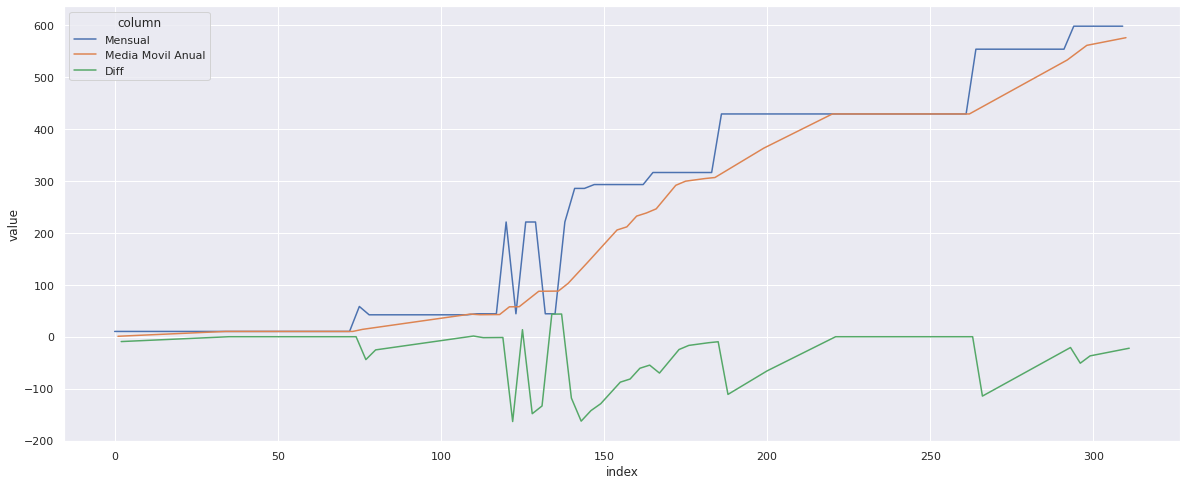

<Figure size 720x1080 with 1 Axes>

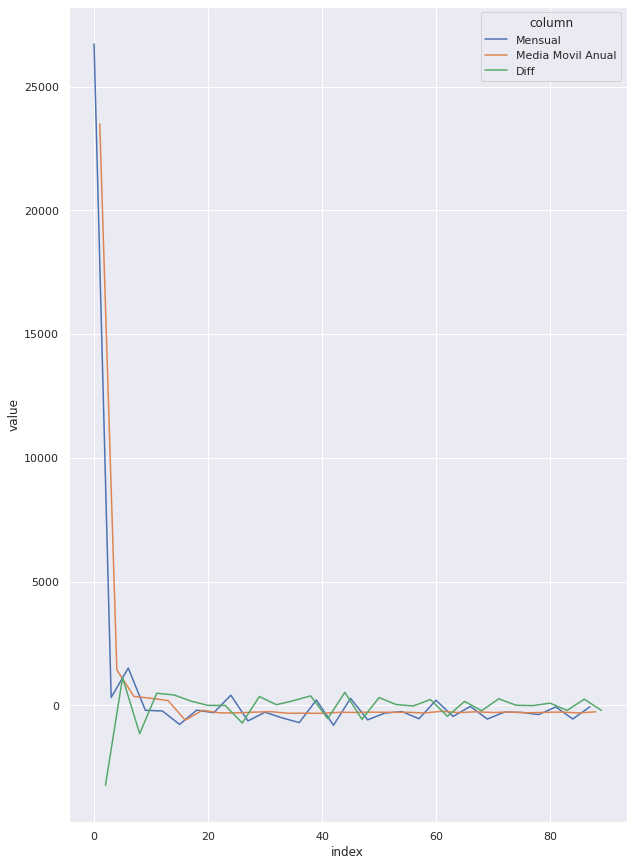

In [416]:
moving_average_plot(edesur, 'cargo_fijo', WINDOW)

Cargo variable:

<Figure size 1440x576 with 1 Axes>

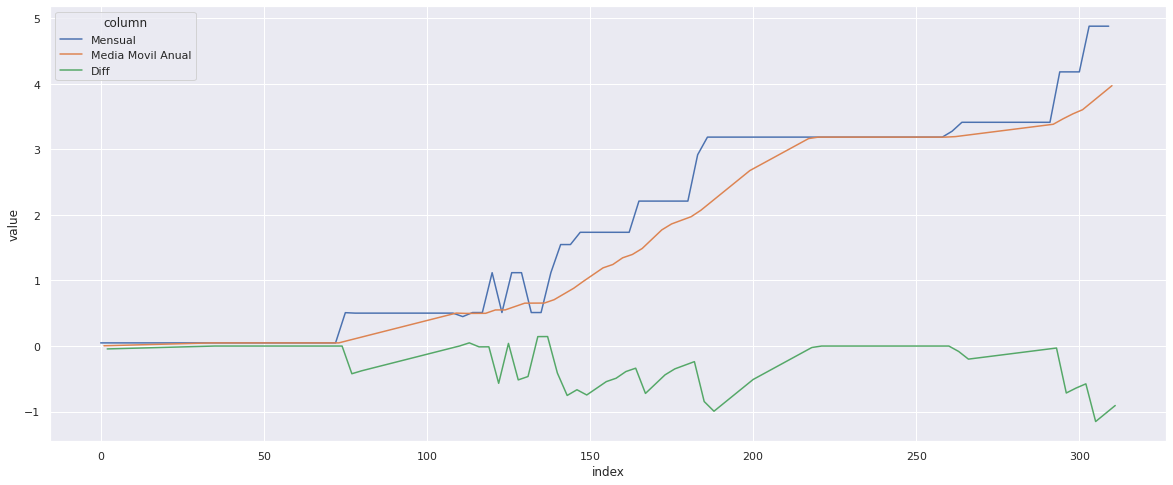

<Figure size 720x1080 with 1 Axes>

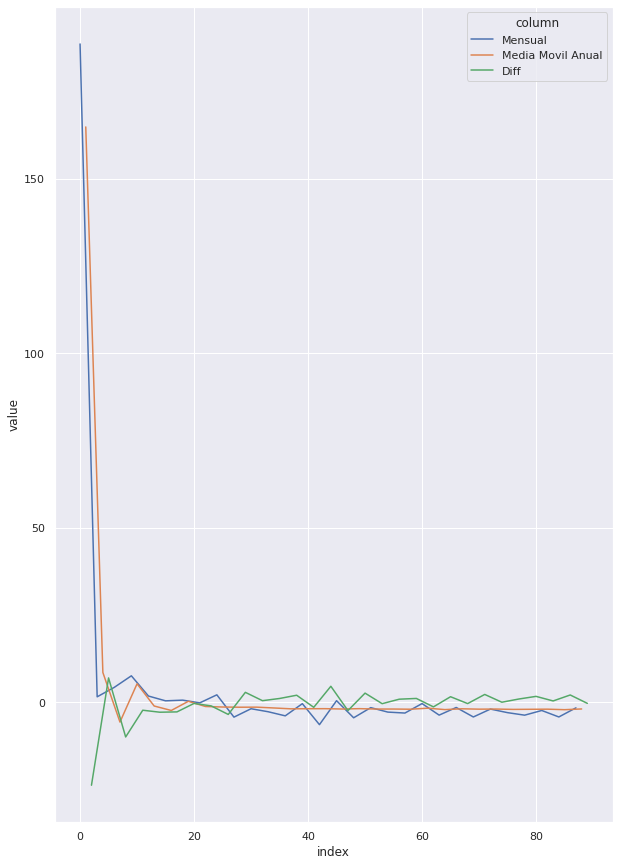

In [417]:
moving_average_plot(edesur, 'cargo_var', WINDOW)

## Auto correlación

La autocorrelación de la señal permite interpretar si la señal original tiene periodicidad y ruido. 

In [418]:
def acf(df, column):
    sns.set(rc = {'figure.figsize':(20, 4)})
    values = edenor[column].values
    plot_acf(x=values, lags=len(values)-1)
    plt.show()

### Edenor

<Figure size 1440x288 with 1 Axes>

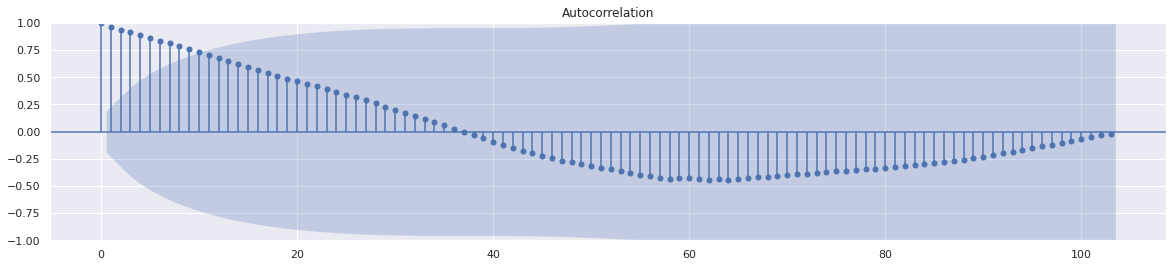

<Figure size 1440x288 with 1 Axes>

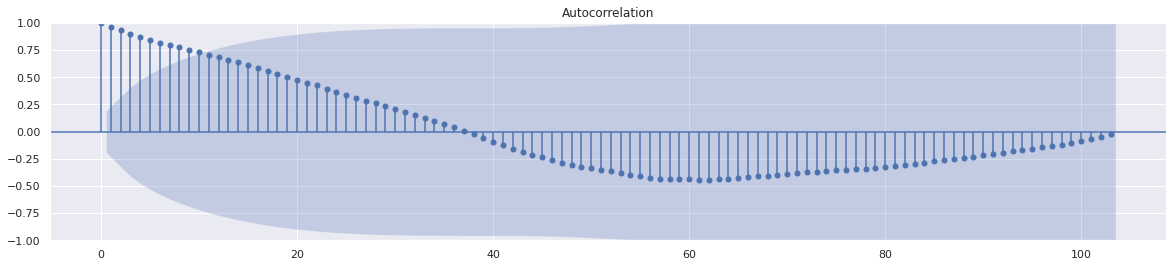

In [419]:
acf(edenor, 'cargo_fijo')
acf(edenor, 'cargo_var')

<Figure size 1440x288 with 1 Axes>

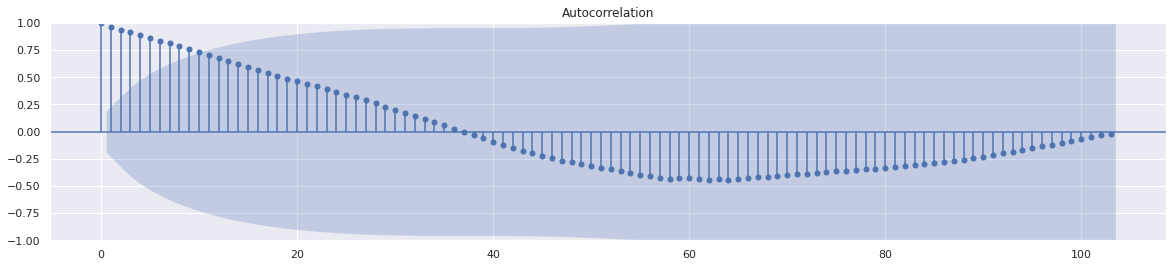

<Figure size 1440x288 with 1 Axes>

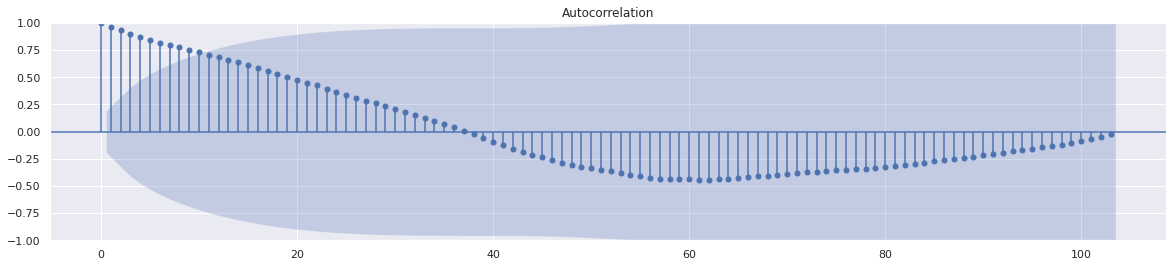

In [420]:
acf(edesur, 'cargo_fijo')
acf(edesur, 'cargo_var')